Selected 30 features:
['Age', 'Gender (Female=1, Male=2)', 'Body Mass Index', 'Waist Circumference', 'Diyabetes Mellitus (No=0, Yes=1)', 'Hypertension (No=0, Yes=1)', 'Hyperlipidemia (No=0, Yes=1)', 'Metabolic syndrome (No=0, Yes=1)', 'AST', 'ALT', 'ALP', 'GGT', 'Total Cholesterol', 'Triglycerides', 'HDL', 'LDL', 'Glucose', 'Insulin', 'Hemoglobin - A1C', 'Leukocyte', 'Hemoglobin', 'Trombosit', 'Creatinine', 'Uric Acid', 'BUN', 'Albumin', 'Total Bilirubin', 'Total Protein', 'Vitamin D', 'Ferritin']

Data Cleaning Summary:
Total samples: 605
Continuous features: 25
Categorical features: 5

Class Distribution:
Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)
1    409
0    196
Name: count, dtype: int64

Positive rate: 67.60%

Training set size: 484
Test set size: 121
Number of features: 30

Model: Random Forest
Accuracy: 0.802
AUC-ROC: 0.807

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66     

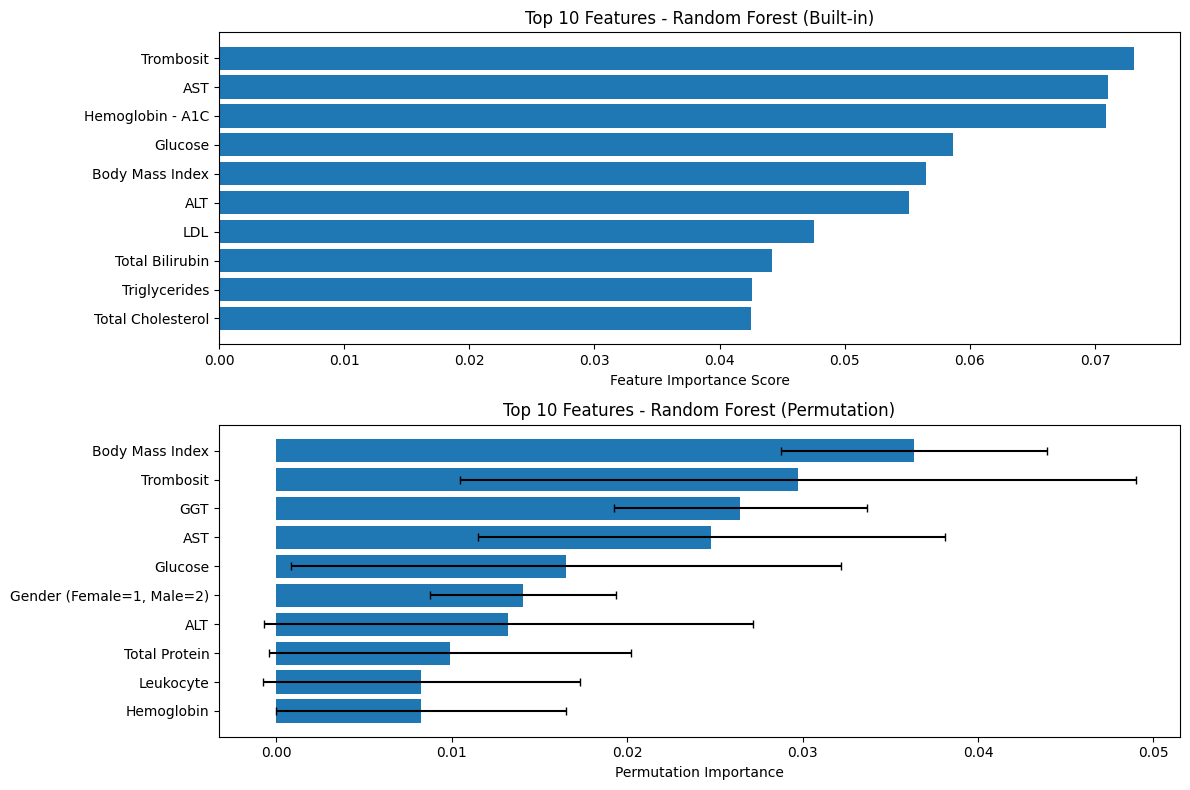

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("../data/NAFLD.xlsx")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load the data (assuming it's already in a DataFrame named df)
# If loading from Excel:
# df = pd.read_excel('NAFLD.xlsx')

# Define the target variable
y = df['Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)']

# Identify columns to EXCLUDE (cheating variables - directly related to fibrosis diagnosis)
cheating_columns = [
    'Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)',
    'Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)',
    'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)',
    'Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)',
    'Fibrosis',  # This appears to be the fibrosis score (0-4)
    'Steatosis',  # Liver fat content - could be borderline but including
    'Activity',   # Inflammatory activity - could be borderline but including
    'NAS score according to Kleiner',  # NAFLD Activity Score
    'NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)',
    'Diagnosis according to SAF (NASH=1, NAFL=2)',
    'Type of Disease (Mild illness=1, Severe illness=2)'
]

# Identify clinically relevant features for liver fibrosis prediction
# Based on medical literature, these include:
selected_features = [
    # Demographic and anthropometric
    'Age',
    'Gender (Female=1, Male=2)',
    'Body Mass Index',
    'Waist Circumference',
    
    # Metabolic syndrome components
    'Diyabetes Mellitus (No=0, Yes=1)',
    'Hypertension (No=0, Yes=1)',
    'Hyperlipidemia (No=0, Yes=1)',
    'Metabolic syndrome (No=0, Yes=1)',
    
    # Liver enzymes (key indicators)
    'AST',
    'ALT',
    'ALP',
    'GGT',
    
    # Lipid profile
    'Total Cholesterol',
    'Triglycerides',
    'HDL',
    'LDL',
    
    # Glucose metabolism
    'Glucose',
    'Insulin',
    'Hemoglobin - A1C',
    
    # Inflammatory markers
    'Leukocyte',
    'Hemoglobin',
    'Trombosit',
    
    # Renal function
    'Creatinine',
    'Uric Acid',
    'BUN',
    
    # Other relevant tests
    'Albumin',
    'Total Bilirubin',
    'Total Protein',
    'Vitamin D',
    'Ferritin'
]

# Filter the dataframe to keep only selected features
X = df[selected_features].copy()

# Check for missing columns
missing_cols = [col for col in selected_features if col not in X.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    # Remove missing columns from selection
    selected_features = [col for col in selected_features if col in X.columns]
    X = df[selected_features].copy()

print(f"Selected {len(selected_features)} features:")
print(selected_features)

# Data Cleaning
def clean_data(X, y):
    """
    Clean the dataset by handling missing values and outliers
    """
    # Remove patients with missing target
    mask = ~y.isna()
    X = X[mask].copy()
    y = y[mask].copy()
    
    # Convert all columns to numeric where possible
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Handle missing values
    # For continuous variables, use median imputation
    continuous_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    # Separate categorical columns (binary/ordinal)
    categorical_cols = []
    for col in X.columns:
        if X[col].nunique() <= 5 and pd.api.types.is_numeric_dtype(X[col]):
            categorical_cols.append(col)
    
    # Remove categorical from continuous
    continuous_cols = [col for col in continuous_cols if col not in categorical_cols]
    
    print(f"\nData Cleaning Summary:")
    print(f"Total samples: {len(X)}")
    print(f"Continuous features: {len(continuous_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")
    
    # Impute missing values
    imputer_cont = SimpleImputer(strategy='median')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    if continuous_cols:
        X[continuous_cols] = imputer_cont.fit_transform(X[continuous_cols])
    if categorical_cols:
        X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])
    
    # Remove outliers using IQR method for continuous variables
    for col in continuous_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers instead of removing to preserve sample size
        X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
        X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])
    
    return X, y, imputer_cont, imputer_cat, continuous_cols, categorical_cols

# Clean the data
X_clean, y_clean, imputer_cont, imputer_cat, continuous_cols, categorical_cols = clean_data(X, y)

# Check class distribution
print("\n" + "="*50)
print("Class Distribution:")
print(y_clean.value_counts())
print(f"\nPositive rate: {y_clean.mean():.2%}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save feature names for later use
feature_names = X_train.columns.tolist()

# Build and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, feature_names):
    """Train and evaluate a model"""
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print('='*50)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
    
    return model, accuracy, auc

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        penalty='l2',
        C=1.0
    )
}

# Evaluate each model
results = {}
for name, model in models.items():
    trained_model, acc, auc = evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name, feature_names
    )
    results[name] = {
        'model': trained_model,
        'accuracy': acc,
        'auc': auc
    }

# Find best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']

print(f"\n{'='*50}")
print(f"Best Model: {best_model_name}")
print(f"Best AUC: {results[best_model_name]['auc']:.3f}")

# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

print(f"\n{'='*50}")
print("Feature Importance Analysis")
print('='*50)

if hasattr(best_model, 'feature_importances_'):
    # For tree-based models - get built-in feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nBuilt-in Feature Importance (Top 15):")
    print(feature_importance.head(15).to_string(index=False))
    
    # Permutation importance
    perm_importance = permutation_importance(
        best_model, X_test_scaled, y_test, 
        n_repeats=10, random_state=42, n_jobs=-1
    )
    
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    print("\nPermutation Importance (Top 15):")
    print(perm_df.head(15).to_string(index=False))
    
    # Create a simple visualization
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 8))
        
        # Plot built-in feature importance
        plt.subplot(2, 1, 1)
        top_features_builtin = feature_importance.head(10)
        plt.barh(top_features_builtin['feature'], top_features_builtin['importance'])
        plt.xlabel('Feature Importance Score')
        plt.title(f'Top 10 Features - {best_model_name} (Built-in)')
        plt.gca().invert_yaxis()
        
        # Plot permutation importance
        plt.subplot(2, 1, 2)
        top_features_perm = perm_df.head(10)
        plt.barh(top_features_perm['feature'], top_features_perm['importance'], 
                xerr=top_features_perm['std'], capsize=3)
        plt.xlabel('Permutation Importance')
        plt.title(f'Top 10 Features - {best_model_name} (Permutation)')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("\nMatplotlib not available for visualization")


